Found 388 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 9s 675ms/step - loss: 0.4656 - accuracy: 0.8553
Epoch 2/10
10/10 [==============================] - 7s 667ms/step - loss: 0.2082 - accuracy: 0.9453
Epoch 3/10
10/10 [==============================] - 7s 668ms/step - loss: 0.1412 - accuracy: 0.9582
Epoch 4/10
10/10 [==============================] - 7s 674ms/step - loss: 0.1157 - accuracy: 0.9646
Epoch 5/10
10/10 [==============================] - 7s 670ms/step - loss: 0.0971 - accuracy: 0.9775
Epoch 6/10
10/10 [==============================] - 7s 742ms/step - loss: 0.0829 - accuracy: 0.9904
Epoch 7/10
10/10 [==============================] - 7s 742ms/step - loss: 0.0738 - accuracy: 0.9904
Epoch 8/10
10/10 [==============================] - 7s 742ms/step - loss: 0.0670 - accuracy: 0.9904
Epoch 9/10
10/10 [==============================] - 7s 744ms/step - loss: 0.0588 - accuracy: 0.9904
Epoch 10/10
3/3 [==============================] - 2s 553ms

C:\Users\88016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 388 images belonging to 2 classes.
Found 462 images belonging to 2 classes.
Found 358 images belonging to 2 classes.
Found 226 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Epoch 1/10
41/41 [==============================] - 39s 905ms/step - loss: 0.1872 - accuracy: 0.9274 - val_loss: 0.2402 - val_accuracy: 0.9136
Epoch 2/10
41/41 [==============================] - 136s 3s/step - loss: 0.0549 - accuracy: 0.9760 - val_loss: 0.3149 - val_accuracy: 0.8827
Epoch 3/10
41/41 [==============================] - 76s 2s/step - loss: 0.0368 - accuracy: 0.9861 - val_loss: 0.1344 - val_accuracy: 0.9414
Epoch 4/10
41/41 [==============================] - 108s 3s/step - loss: 0.0213 - accuracy: 0.9915 - val_loss: 0.1904 - val_accuracy: 0.9198
Epoch 5/10
41/41 [==============================] - 115s 3s/step - loss: 0.0153 - accuracy: 0.9969 - val_loss: 0.1364 - val_accuracy: 0.9352
Epoch 6/10
41/41 [==============================] - 156s 4s/step - loss: 0.0148 - accurac

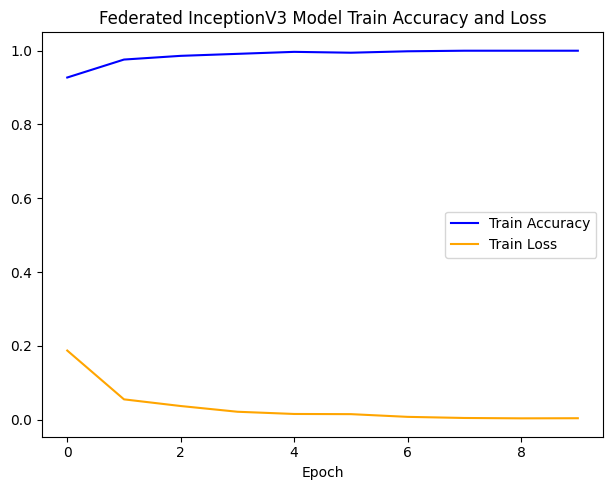

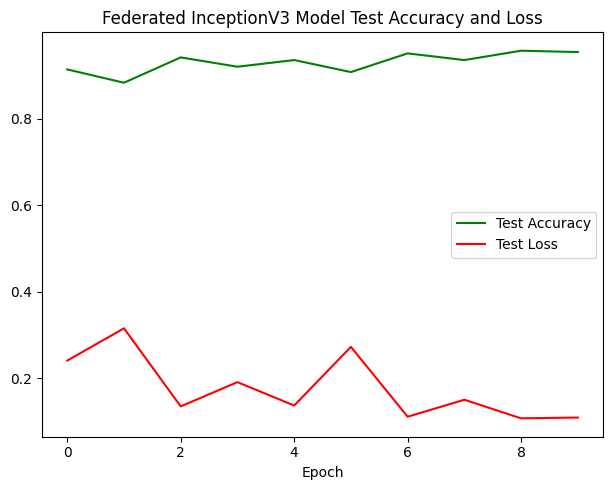

51/51 [==============================] - 43s 799ms/step


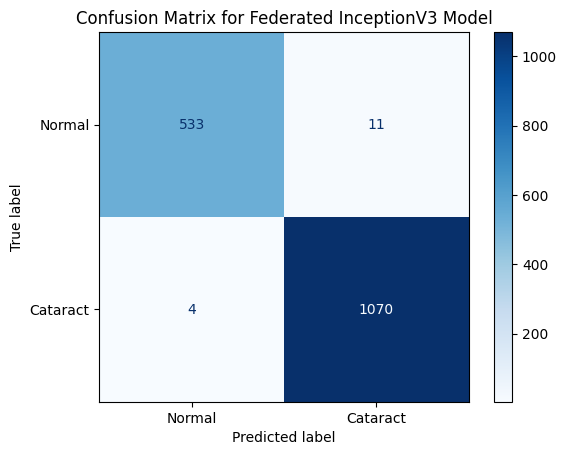

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       544
    Cataract       0.99      1.00      0.99      1074

    accuracy                           0.99      1618
   macro avg       0.99      0.99      0.99      1618
weighted avg       0.99      0.99      0.99      1618



: 

In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define the InceptionV3-based model
def create_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a function to load data from a local dataset
def load_data(client_folder):
    datagen = ImageDataGenerator(rescale=1./255)
    
    data_generator = datagen.flow_from_directory(
        client_folder,
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary'
    )
    
    data, labels = [], []
    for batch in data_generator:
        data.extend(batch[0])
        labels.extend(batch[1])
        if len(data) >= data_generator.n:
            break
    
    return np.array(data), np.array(labels)

def custom_federated_averaging(global_model, local_model, weight):
    for global_layer, local_layer in zip(global_model.layers, local_model.layers):
        weights = [weight * global_w + (1 - weight) * local_w for global_w, local_w in zip(global_layer.get_weights(), local_layer.get_weights())]
        global_layer.set_weights(weights)
    return global_model

def train_local_cnn_model(local_model, data, labels, epsilon):
    history = local_model.fit(data, labels, epochs=10, batch_size=32)
    
    for layer in local_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.set_weights([w + np.random.normal(0, epsilon, w.shape) for w in layer.get_weights()])
    
    return local_model, history

def split_train_test_data(data, labels, test_ratio=0.2):
    num_samples = len(data)
    num_test_samples = int(test_ratio * num_samples)

    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]

    test_data = data[:num_test_samples]
    test_labels = labels[:num_test_samples]
    train_data = data[num_test_samples:]
    train_labels = labels[num_test_samples:]

    return train_data, train_labels, test_data, test_labels

# Main block
if __name__ == '__main__':
    client_folders = ['ds1', 'ds2', 'ds3', 'ds4', 'ds5']
    current_dir = os.getcwd()
    local_models = [create_inceptionv3_model() for _ in client_folders]
    train_metrics = []
    test_metrics = []
    
    best_accuracies = [0.0] * len(client_folders)
    best_local_models = [None] * len(client_folders)
    
    epsilon = 0.1
    local_histories = []

    for i, client_folder in enumerate(client_folders):
        client_folder_path = os.path.join(current_dir, client_folder)
        data, labels = load_data(client_folder_path)
        train_data, train_labels, test_data, test_labels = split_train_test_data(data, labels)

        local_model, history = train_local_cnn_model(local_models[i], train_data, train_labels, epsilon)

        local_histories.append(history)

        train_loss, train_accuracy = local_models[i].evaluate(train_data, train_labels, verbose=0)
        train_predictions = (local_models[i].predict(train_data) > 0.5).astype('int32')

        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1_score = f1_score(train_labels, train_predictions)

        train_metrics.append((train_accuracy, train_precision, train_recall, train_f1_score))

        test_loss, test_accuracy = local_models[i].evaluate(test_data, test_labels, verbose=0)
        test_predictions = (local_models[i].predict(test_data) > 0.5).astype('int32')

        test_precision = precision_score(test_labels, test_predictions)
        test_recall = recall_score(test_labels, test_predictions)
        test_f1_score = f1_score(test_labels, test_predictions)

        test_metrics.append((test_accuracy, test_precision, test_recall, test_f1_score))

        test_report = classification_report(test_labels, test_predictions, target_names=['Normal', 'Cataract'], zero_division=1)
        train_report = classification_report(train_labels, train_predictions, target_names=['Normal', 'Cataract'], zero_division=1)

        print(f'Local Model {i+1} Train Accuracy: {train_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Train Precision: {train_precision:.2f}')
        print(f'Local Model {i+1} Train Recall: {train_recall:.2f}')
        print(f'Local Model {i+1} Train F1-score: {train_f1_score:.2f}\n')
        print(f'Local Model {i+1} Test Accuracy: {test_accuracy * 100:.2f}%')
        print(f'Local Model {i+1} Test Precision: {test_precision:.2f}')
        print(f'Local Model {i+1} Test Recall: {test_recall:.2f}')
        print(f'Local Model {i+1} Test F1-score: {test_f1_score:.2f}\n')
        print(f'Local Model {i+1} Classification Report (Train Data):')
        print(train_report)
        print(f'Local Model {i+1} Classification Report (Test Data):')
        print(test_report)
        
        if test_accuracy > best_accuracies[i]:
            best_accuracies[i] = test_accuracy
            best_local_models[i] = local_models[i]

    total_best_accuracy = sum(best_accuracies)
    weights = [accuracy / total_best_accuracy for accuracy in best_accuracies]
    global_model = create_inceptionv3_model()

    for i, best_local_model in enumerate(best_local_models):
        global_model = custom_federated_averaging(global_model, best_local_model, weights[i])

    # Update local models based on the global model
    for i in range(len(client_folders)):
        local_models[i] = create_inceptionv3_model()
        local_models[i].set_weights(global_model.get_weights())

    global_model.save('global_model_inceptionv3.h5')

    global_model = tf.keras.models.load_model('global_model_inceptionv3.h5')
    global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    global_data, global_labels = [], []
    for client_folder in client_folders:
        client_folder_path = os.path.join(current_dir, client_folder)
        data, labels = load_data(client_folder_path)
        global_data.extend(data)
        global_labels.extend(labels)

    global_data, global_labels = np.array(global_data), np.array(global_labels)

    for i, local_model in enumerate(local_models):
        local_model.save(f'local_model_ds{i+1}_inceptionv3.h5')

    history_global = global_model.fit(global_data, global_labels, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_global.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history_global.history['loss'], label='Train Loss', color='orange')
    plt.title('Federated InceptionV3 Model Train Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_global.history['val_accuracy'], label='Test Accuracy', color='green')
    plt.plot(history_global.history['val_loss'], label='Test Loss', color='red')
    plt.title('Federated InceptionV3 Model Test Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    predictions = (global_model.predict(global_data) > 0.5).astype('int32')
    cm = confusion_matrix(global_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Cataract'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Federated InceptionV3 Model')
    plt.show()

    report = classification_report(global_labels, predictions, target_names=['Normal', 'Cataract'], zero_division=1)
    print("Classification Report:")
    print(report)

    train_loss, train_accuracy = global_model.evaluate(global_data, global_labels, verbose=0)
    train_predictions = (global_model.predict(global_data) > 0.5).astype('int32')

    train_precision = precision_score(global_labels, train_predictions)
    train_recall = recall_score(global_labels, train_predictions)
    train_f1_score = f1_score(global_labels, train_predictions)

    print(f'Federated InceptionV3 Model Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Precision: {train_precision:.2f}')
    print(f'Recall: {train_recall:.2f}')
    print(f'F1-score: {train_f1_score:.2f}\n')

    test_loss, test_accuracy = global_model.evaluate(global_data, global_labels, verbose=0)
    test_predictions = (global_model.predict(global_data) > 0.5).astype('int32')

    test_precision = precision_score(global_labels, test_predictions)
    test_recall = recall_score(global_labels, test_predictions)
    test_f1_score = f1_score(global_labels, test_predictions)

    print(f'Federated InceptionV3 Model Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Precision: {test_precision:.2f}')
    print(f'Recall: {test_recall:.2f}')
    print(f'F1-score: {test_f1_score:.2f}\n')
